# Concept Drift and Online Learning

We are using the following acronyms:

1. **Original Model OM**: . It refers to a model trained and not pruned.
1. **Pruned Model PM**: . It refers to a pruned version of the **OM**.
1. **Online Learning OL**: mechanism to train a model iteratively considering 1 sample at a time, calling the *model.learn_one(...)* function for each sample.
1. **Typical Learning TL**: mechanism to train a model in the typical way, dividing the train set in batches and shuffling it at each epoch of the training.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
import numpy as np
import pandas as pd
import threadpoolctl
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython import get_ipython
import os

from river import drift, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, get_scorer
from intellect.model.ensembles import WrapRiverEnsemble
from intellect.model.sklearn.model import EnhancedMlpClassifier
from intellect.model.sklearn.pruning import globally_unstructured_connections_l1
from intellect.ranking import prune_search
from intellect.dataset import Dataset
from intellect.io import create_dir, dump, load
from intellect.scoring import compute_metric_incremental
from intellect.inspect import set_seed

#threadpoolctl.threadpool_limits(limits=2);
mpl.rcParams['figure.dpi']= 70
pd.set_option("display.max_columns", 100)

Define prameters and neural network architecture.

In [2]:
# Parameters

# training
TRAIN_SIZE = 0.1
TRAIN_EPOCHS = 100
EPOCS_WO_IMPROVE = TRAIN_EPOCHS

# neural network architecture
HIDDEN_UNITS = 32
HIDDEN_LAYERS = 5
DROPOUT_HIDDEN = 0.5

BATCH_SIZE = 64
PRUNING_AMOUNTS = (0.1, 0.35, 0.6, 0.85)

# eval metrics
METRIC_NAME = "accuracy"
INCREMENTAL_METRIC_NAME = "Accuracy"

#dataset
LABEL = "Label"
DATASET="../../datasets/IOT2020-drifts/dataset.csv"

Generate the output directory name from the name of the notebook.

In [3]:
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']

OUTPUT_DIR = os.path.basename(path).split(".")[0] + "_output/"

Load sklearn scorer to later compute feature importance.

In [4]:
ORIG_SCORER = get_scorer(METRIC_NAME)

Load dataset and normalize data within 0-1.

In [5]:
def load_ds():
    set_seed()
    df = pd.read_csv(DATASET, index_col=None)
    label = df.pop(LABEL)
    X_normalized = df.apply(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    X_normalized[LABEL] = label

    X_train_normalized, X_test_normalized = train_test_split(X_normalized, train_size = TRAIN_SIZE, shuffle=False)
    train_labels = X_train_normalized.pop(LABEL)
    test_labels = X_test_normalized.pop(LABEL)
    return Dataset(data=X_train_normalized, label=train_labels, label_type=train_labels, shuffle=False), Dataset(data=X_test_normalized, label=test_labels, label_type=test_labels, shuffle=False)

train_ds, test_ds = load_ds()

Define utility functions to: 

1. Train a model from scratch using **OL**, taking 1 sample at a time
1. Train a model from scratch using **TL**, in a traditional fashion
1. Test a trained model **with** and **without** continuous learning
1. Prune a model with the given ratios and test each of the obtained model **with** and **without** continuous learning
1. Plot functions for trained and tested models

In [6]:
# train with online learning
def wrap_train(model: EnhancedMlpClassifier, save_path: str, ds: Dataset=train_ds):
    set_seed()
    ypred, ytrue, ylabels, drifts = model.continuous_learning(ds, epochs=1, batch_size=1)
    model.save(f"{save_path}_train")
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.DataFrame({"Accuracy": accuracy_score(ytrue, ypred), "Recall": recall_score(ytrue, ypred),
                           "Precision": precision_score(ytrue, ypred), "F1": f1_score(ytrue, ypred), "Drifts": str(drifts)}, index=["During OL Train"])
    df2 = pd.DataFrame({"Labels": ytrue, "Predictions": ypred, "Type": ylabels})
    dump(df, f"{save_path}_train_incremental.csv")
    dump(df2, f"{save_path}_train_incremental_raw.csv")
    return df, df2

# plot trained or tested model incremental metric
def wrap_plot(path: str, path_raw: str, save_path: str):
    df = load(path, index_col=0)
    df2 = load(path_raw, index_col=0)
    m_incremental_with = m_incremental_without = None
    if "Predictions" in df2:
        m_incremental_with = compute_metric_incremental(df2["Labels"], df2["Predictions"], metric=INCREMENTAL_METRIC_NAME)
    else:
        m_incremental_with = compute_metric_incremental(df2["Labels"], df2["Predictions With OL"], metric=INCREMENTAL_METRIC_NAME)
        m_incremental_without = compute_metric_incremental(df2["Labels"], df2["Predictions Without OL"], metric=INCREMENTAL_METRIC_NAME)

    ax = pd.DataFrame(m_incremental_with).plot(legend=False, ylabel=INCREMENTAL_METRIC_NAME, xlabel="# Samples")
    if m_incremental_without is not None:
        pd.DataFrame(m_incremental_without).plot(ax=ax, legend=False)
        cd = np.array(df.loc["With OL", "Drifts"].split()[1:-1], dtype=float).astype("int")
        ax.scatter(x=cd, y=[m_incremental_with[i] for i in cd], c="r")
        ax.legend(["With OL", "Without OL"])
    else:
        ax.legend(["With OL"])
    ax.minorticks_on()
    plt.savefig(save_path)
    display(df)
    plt.show()

# train with traditional learning
def wrap_train_normal(prune_amount=None):
    set_seed()
    save_path = f"om_tl_train_{BATCH_SIZE}"
    if prune_amount is not None:
        om = globally_unstructured_connections_l1(EnhancedMlpClassifier.load(OUTPUT_DIR + save_path), prune_amount).clone(init=True)
        save_path = f"pm_tl_retrained_{BATCH_SIZE}_{prune_amount}"
    else:
        om = EnhancedMlpClassifier(train_ds.classes, hidden_layer_sizes=(HIDDEN_UNITS,)*HIDDEN_LAYERS, dropout=DROPOUT_HIDDEN, drift_detector=drift.ADWIN(),
                                                       batch_size=BATCH_SIZE, max_iter=TRAIN_EPOCHS, validation_fraction=0.)

    om.fit(train_ds.X, train_ds.y)
    om.save(OUTPUT_DIR + save_path)
    dump(pd.DataFrame({"loss_train": om.loss_curve_}), OUTPUT_DIR + f"{save_path}_history.csv")

# plot trained model with traditional learning
def wrap_train_normal_plot(save_name:str):
    df = load(f"{save_name}_history.csv")
    ax = df[f"loss_train"].plot(legend=False, ylabel="Score", xlabel="# Epochs")
    ax.minorticks_on()
    ax.legend(["Loss"])
    plt.savefig(f"{save_name}_histories_diff.pdf")
    plt.show()

# test a model with and without online learning
def wrap_test(model: EnhancedMlpClassifier, save_path: str, ds: Dataset=test_ds, dump_csv=True):
    set_seed()
    yp_normal = model.predict(ds.X)
    
    ypred, ytrue, ylabels, drifts  = model.continuous_learning(ds, epochs=1, batch_size=1)
    model.save(f"{save_path}_test")

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        df = pd.DataFrame({"Accuracy": [accuracy_score(ytrue, ypred), accuracy_score(ytrue, yp_normal)], "Recall": [recall_score(ytrue, ypred), recall_score(ytrue, yp_normal)],
                           "Precision": [precision_score(ytrue, ypred), precision_score(ytrue, yp_normal)], "F1": [f1_score(ytrue, ypred), f1_score(ytrue, yp_normal)], "Drifts": [str(drifts), ""]},
                           index=["With OL", "Without OL"])
    df2 = pd.DataFrame({"Labels": ytrue, "Predictions Without OL": yp_normal, "Predictions With OL": ypred, "Type": ylabels})
    if dump_csv:
        dump(df, f"{save_path}_test_incremental.csv")
        dump(df2, f"{save_path}_test_incremental_raw.csv")
    return df, df2

# test model pruned with different ratios, with and without online learning
def wrap_prune_ratios_test(save_name: str, ds=test_ds):
    dff, dff2 = pd.DataFrame(), pd.DataFrame()
    for amount in PRUNING_AMOUNTS:
        x = EnhancedMlpClassifier.load(save_name)
        x = globally_unstructured_connections_l1(x, amount)
        df, df2  = wrap_test(x, f"{save_name}_{amount}", ds=ds, dump_csv=False)
        df["Prune Ratio"] = df2["Prune Ratio"] = amount
        dff, dff2 = pd.concat((dff, df)), pd.concat((dff2, df2))
    dump(dff, f"{save_name}_diff.csv")
    dump(dff2, f"{save_name}_diff_raw.csv")

# plot results of the pruning
def wrap_prune_ratios_plot(save_name: str):
    df: pd.DataFrame = load(f"{save_name}_diff.csv", index_col=0)
    df2: pd.DataFrame = load(f"{save_name}_diff_raw.csv", index_col=0)
    amounts = df["Prune Ratio"].unique()
    _, axes = plt.subplots(nrows=1, ncols=len(amounts), figsize=(20,5), sharex=True, sharey=True)
    for ax, amount in zip(axes, amounts):
        m_incremental_without = compute_metric_incremental(df2[df2["Prune Ratio"] == amount]["Labels"], df2[df2["Prune Ratio"] == amount]["Predictions Without OL"], metric=INCREMENTAL_METRIC_NAME)
        m_incremental_with = compute_metric_incremental(df2[df2["Prune Ratio"] == amount]["Labels"], df2[df2["Prune Ratio"] == amount]["Predictions With OL"], metric=INCREMENTAL_METRIC_NAME)
        pd.DataFrame(m_incremental_without).plot(ax=ax, legend=False, ylabel=INCREMENTAL_METRIC_NAME, xlabel="# Samples")
        pd.DataFrame(m_incremental_with).plot(ax=ax, legend=False)
        cd = np.array(df[df["Prune Ratio"] == amount].loc["With OL", "Drifts"].split()[1:-1], dtype=float).astype("int")
        ax.scatter(x=cd, y=[m_incremental_with[i] for i in cd], c="r")
        ax.minorticks_on()
        ax.legend(["Without OL", "With OL"])
    plt.savefig(f"{save_name}_diff.pdf")
    display(df)
    plt.show()

In [7]:
create_dir(OUTPUT_DIR)

## Train using Online learning and TEST in both cases

### Original Model Training

We leverage the **OL** algorithm for training the model against the train portion of the dataset. Each sample is learned individually and only once.

In [8]:
set_seed()
om = EnhancedMlpClassifier(train_ds.classes, hidden_layer_sizes=(HIDDEN_UNITS,)*HIDDEN_LAYERS,
                            dropout=DROPOUT_HIDDEN, drift_detector=drift.ADWIN(), max_iter=TRAIN_EPOCHS, validation_fraction=0.)
wrap_train(om, OUTPUT_DIR + "om_ol", ds=train_ds);

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:01<00:00, 568.93it/s]


### Original Model Train Plot
And we visualize the resulting data for the training process.

,Accuracy,Recall,Precision,F1,Drifts
During OL Train,0.936,0.998294,0.9375,0.966942,[]


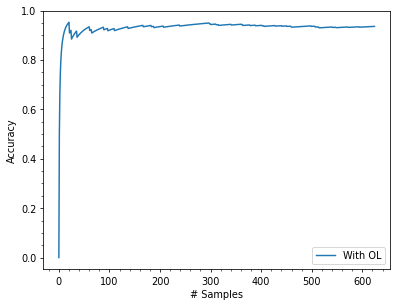

In [9]:
wrap_plot(OUTPUT_DIR + "om_ol_train_incremental.csv",
          OUTPUT_DIR + "om_ol_train_incremental_raw.csv",
          OUTPUT_DIR + "om_ol_train_diff.pdf")

### Original Model Testing
Now we proceed with testing the obtained model against the test set **with** and **without** using online learning for the test.

In [10]:
wrap_test(EnhancedMlpClassifier.load(OUTPUT_DIR + "om_ol_train"), OUTPUT_DIR + "om_ol", ds=test_ds);

  4%|▎         | 206/5627 [00:00<00:09, 547.87it/s]

100%|██████████| 5627/5627 [00:09<00:00, 595.50it/s]


### Original Model Testing Plot
And we visualize the resulting data for the test.

,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942598,0.999811,0.942766,0.970451,[]
Without OL,0.942776,1.000000,0.942776,0.970545,NaN


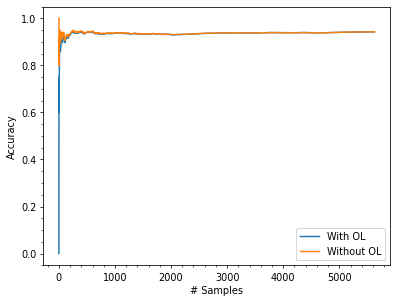

In [11]:
wrap_plot(OUTPUT_DIR + "om_ol_test_incremental.csv",
          OUTPUT_DIR + "om_ol_test_incremental_raw.csv",
          OUTPUT_DIR + "om_ol_test_diff.pdf")

### Pruning Original Model
We now take one step back in the process. Suppose we're at the end of the training phase and we decide that somehow our model's architecture is too big. Hence we decide to prune it, to see the effects in concept drifts and see il pruning helps or not the model, which might be overfit to data.

In [12]:
for prune_amount, score, _ in prune_search(EnhancedMlpClassifier.load(OUTPUT_DIR + "om_ol_train"), train_ds,
                                                            globally_unstructured_connections_l1, PRUNING_AMOUNTS, metric=ORIG_SCORER._score_func):
    print("Prune amount", prune_amount, METRIC_NAME, "Score", score)

Prune amount 0.1 accuracy Score 0.9376
Prune amount 0.35 accuracy Score 0.9376
Prune amount 0.6 accuracy Score 0.9376
Prune amount 0.85 accuracy Score 0.9376


However, we notice that independently by the pruning amount, the obtained model behaves similarly, achieving the same accuracy score. This can be due to the low amount of data in the input set, and the too much complexity of our neural network.

### Testing of the Pruned Models
We proceed by testing the pruned models to check for both differences with the previous original model and between themselves.

In [13]:
wrap_prune_ratios_test(OUTPUT_DIR + "om_ol_train")

  0%|          | 0/5627 [00:00<?, ?it/s]

100%|██████████| 5627/5627 [00:09<00:00, 581.42it/s]


### Pruned Models Plots
Visualize the obtained output data from the test.

,Accuracy,Recall,Precision,F1,Drifts,Prune Ratio
With OL,0.942598,0.999811,0.942766,0.970451,[],0.10
Without OL,0.942776,1.000000,0.942776,0.970545,NaN,0.10
With OL,0.942598,0.999811,0.942766,0.970451,[],0.35
Without OL,0.942776,1.000000,0.942776,0.970545,NaN,0.35
With OL,0.942598,0.999811,0.942766,0.970451,[],0.60
Without OL,0.942776,1.000000,0.942776,0.970545,NaN,0.60
With OL,0.942598,0.999811,0.942766,0.970451,[],0.85
Without OL,0.942776,1.000000,0.942776,0.970545,NaN,0.85


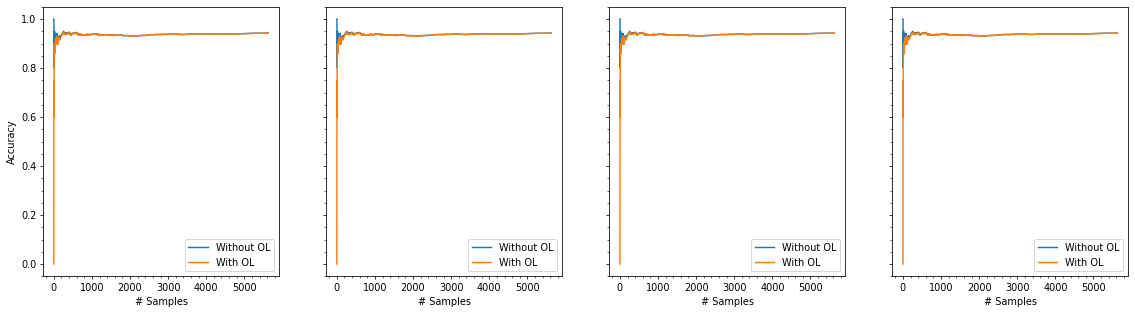

In [14]:
wrap_prune_ratios_plot(OUTPUT_DIR + "om_ol_train")

Interestingly, all the pruned model were able to achieve the same pertformance of 0.970 f1-score, independently by their pruning ratio. They follow the same behaviour as the original model([here](#original-model-testing-plot)). In this case with DROPOUT, pruning doesn't influence the outcome.

### Training from scratch of a pruned model with chosen ratio

Lastly but not least, let's simulate the training and testing phase from scratch using a model with the pruning ratio of **0.35** also during the training phase, and record the differences.

In [15]:
best_prune_amount = 0.35

### Best Pruned Model Training
Retake the training phase with a pruned model from scratch.

In [16]:
wrap_train(globally_unstructured_connections_l1(EnhancedMlpClassifier.load(OUTPUT_DIR + "om_ol_train"), best_prune_amount).clone(init=True),
           OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}", ds=train_ds);

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:01<00:00, 566.66it/s]


### Best Pruned Model Training Plot
Let's see the result of the training.

,Accuracy,Recall,Precision,F1,Drifts
During OL Train,0.936,0.998294,0.9375,0.966942,[]


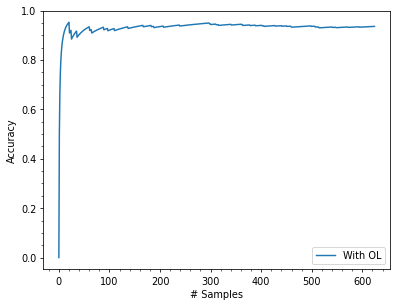

In [17]:
wrap_plot(OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_train_incremental.csv",
          OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_train_incremental_raw.csv",
          OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_train_diff.pdf")

The pruned model from scratch was not able to overtake the original model during the mere train phase with online learning. The final f1-score is 0.966 with respect to 0.970 (see [here](#original-model-train-plot))

### Retrained Pruned Model Test
Let's continue with the testing phase with and without online learning.

In [18]:
wrap_test(EnhancedMlpClassifier.load(OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_train"),
          OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}", ds=test_ds);

  0%|          | 0/5627 [00:00<?, ?it/s]

100%|██████████| 5627/5627 [00:09<00:00, 575.99it/s]


### Retrained Pruned Model Test Plot

Visualize the output   data.

,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942598,0.999811,0.942766,0.970451,[]
Without OL,0.942776,1.000000,0.942776,0.970545,NaN


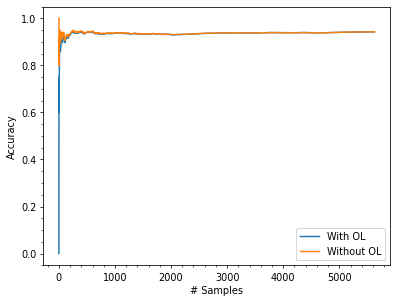

In [20]:
wrap_plot(OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_test_incremental.csv",
          OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_test_incremental_raw.csv",
          OUTPUT_DIR + f"pm_ol_retrained_{best_prune_amount}_test_diff.pdf")

Interestingly, the model pruned from scratch achieves the same performance of the other models anyway.

## Training an Original Model in the Traditional Fashion and Testing in both cases

In this section, we leverage MLP models trained in the traditional way, meaning using the test set for multiple epochs of training using as an early stopping condition. Note that there is no validation set here, to be coherent with data presented in the PWPAE paper. The idea is to check whether also using a traditionally-obtained model is susceptible to concept drifts, and if also in this case the pruning can help.

### Traditional Model Train

We now train the original model.

In [21]:
wrap_train_normal()

### Traditional Model Train Plot

We visualize the history of the training process, from the loss functions perspective.

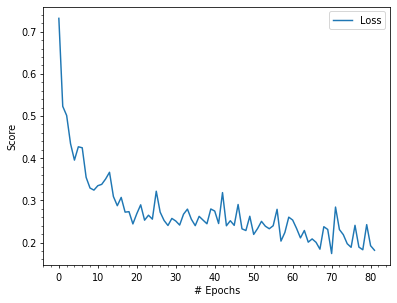

In [22]:
wrap_train_normal_plot(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}")

### Traditional Model Test

Let's test this obtained traditional model with and without online learning, and compare.

In [23]:
wrap_test(EnhancedMlpClassifier.load(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}"), OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}");

  1%|          | 33/5627 [00:00<00:17, 327.83it/s]

100%|██████████| 5627/5627 [00:09<00:00, 599.16it/s]


### Traditional Model Test Plot

Visualize the outcome.

,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942598,0.999811,0.942766,0.970451,[]
Without OL,0.942776,1.000000,0.942776,0.970545,NaN


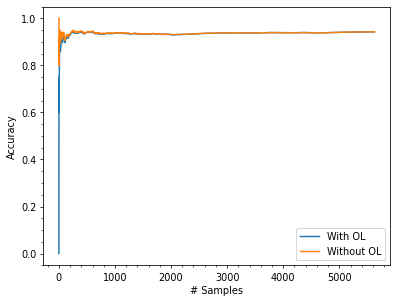

In [24]:
wrap_plot(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}_test_incremental.csv",
          OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}_test_incremental_raw.csv",
          OUTPUT_DIR + "om_tl_test_diff.pdf")

As for the previous tests, adopting online learning here doesn't play any role in the model's outcome.

### Traditional Model Pruning

We proceed as in the previous section, with pruning the training model and re-testing it.

In [25]:
for prune_amount, score, _ in prune_search(EnhancedMlpClassifier.load(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}"), train_ds, globally_unstructured_connections_l1, PRUNING_AMOUNTS, metric=ORIG_SCORER._score_func):
    print("Prune amount", prune_amount, METRIC_NAME, "Score", score)

Prune amount 0.1 accuracy Score 0.9376
Prune amount 0.35 accuracy Score 0.9376
Prune amount 0.6 accuracy Score 0.9376
Prune amount 0.85 accuracy Score 0.9376


However, we notice that independently by the pruning amount, the obtained model behaves similarly, achieving the same accuracy score. This can be due to the low amount of data in the input set, and the too much complexity of our neural network.

### Traditional Pruned Models Test

Proceed with the testing phase, with and without online learning.

In [26]:
wrap_prune_ratios_test(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}")

  0%|          | 0/5627 [00:00<?, ?it/s]

100%|██████████| 5627/5627 [00:09<00:00, 575.21it/s]


### Traditional Pruned Models Test Plots

Visualize the outcome, comparing the metrics.

,Accuracy,Recall,Precision,F1,Drifts,Prune Ratio
With OL,0.964708,0.895819,0.898488,0.897151,[ 896. 1760. 1952. 2688. 13184. 14304. 153...,0.10
Without OL,0.871629,0.281700,0.907285,0.429916,NaN,0.10
With OL,0.961960,0.892164,0.887097,0.889623,[ 896. 1792. 2368. 13152. 14304. 15328. 192...,0.35
Without OL,0.871236,0.269591,0.934283,0.418440,NaN,0.35
With OL,0.965336,0.880969,0.914177,0.897266,[ 416. 928. 1792. 2112. 2496. 13152. 143...,0.60
Without OL,0.881168,0.311172,0.991266,0.473657,NaN,0.60
With OL,0.876222,0.325565,0.876384,0.474763,[ 128. 320. 448. 1792. 2176. 2304. 131...,0.85
Without OL,0.174930,0.999543,0.172312,0.293950,NaN,0.85


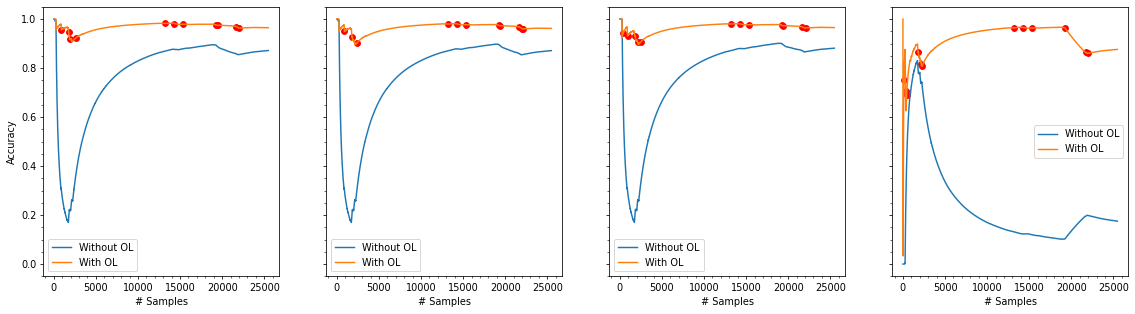

In [12]:
wrap_prune_ratios_plot(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}")

Differently than in the previous case ([here](#pruned-models-plots)), here the most performant models is that with a pruning ratio of 0.6 with a score of 0.897, which is still significantly lower than the previous case. The case with a pruning ratio of 0.85 does not lead to any improvemenet at all, since the obtained model keeps a very low f1-score.

### Best Traditional Pruned Model Retraining

As in the previous case, now we suppose to use that pruning ratio since the beginning, training a pruned model and then testing it.

In [27]:
best_prune_amount = 0.6

In [28]:
wrap_train_normal(prune_amount=best_prune_amount)

### Best Traditional Pruned Model Retraining Plot

And visualize the training result.

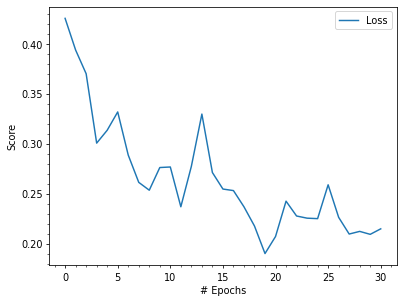

In [29]:
wrap_train_normal_plot(OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}")

### Best Traditional Pruned Model Test

Proceed with the testing phase.

In [30]:
wrap_test(EnhancedMlpClassifier.load(OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}"),
          OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}", ds=test_ds);

  0%|          | 0/5627 [00:00<?, ?it/s]

100%|██████████| 5627/5627 [00:09<00:00, 570.66it/s]


### Best Traditional Pruned Model Test Plot

Let's see the outcome of the testing phase.

,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942598,0.999811,0.942766,0.970451,[]
Without OL,0.942776,1.000000,0.942776,0.970545,NaN


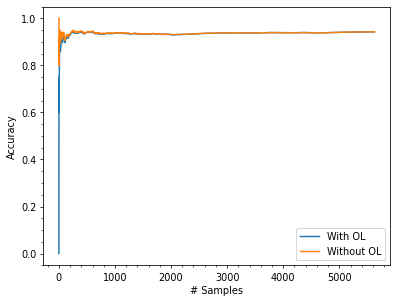

In [31]:
wrap_plot(OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}_test_incremental.csv",
          OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}_test_incremental_raw.csv",
          OUTPUT_DIR + f"pm_tl_retrained_{BATCH_SIZE}_{best_prune_amount}_test_diff.pdf")

Here we notice the very high f1-score of 0.970, equal to the one obtained in the previous steps. This score is above those obtained by the original model trained in the traditional fashion, pointing out the importance of pruning.

### Ensemble with Online Learning and both Original Model and Pruned Ones

Now, run the online learning of a **LeverageBagging**. This classifier leverages multiple underlying copies of the model for the training and inference of the samples.

Start with a new untrained Mlp and create and ensemble of 3 models. Train using OL and then test in both ways.

In [32]:
set_seed()

x = EnhancedMlpClassifier(train_ds.classes, hidden_layer_sizes=(HIDDEN_UNITS,)*HIDDEN_LAYERS, dropout=DROPOUT_HIDDEN, drift_detector=drift.ADWIN(),
                                                       max_iter=TRAIN_EPOCHS, validation_fraction=0., batch_size=1)
bag = WrapRiverEnsemble(ensemble.LeveragingBaggingClassifier, model=x, n_models=3)
wrap_train(bag, OUTPUT_DIR + "bagging_om", ds=train_ds);

  0%|          | 0/625 [00:00<?, ?it/s]

100%|██████████| 625/625 [00:14<00:00, 43.12it/s]


In [33]:
wrap_test(load(OUTPUT_DIR + "bagging_om_train"), OUTPUT_DIR + "bagging_om", ds=test_ds);

100%|██████████| 5627/5627 [02:13<00:00, 42.11it/s]


,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942776,1.0,0.942776,0.970545,[]
Without OL,0.942776,1.0,0.942776,0.970545,NaN


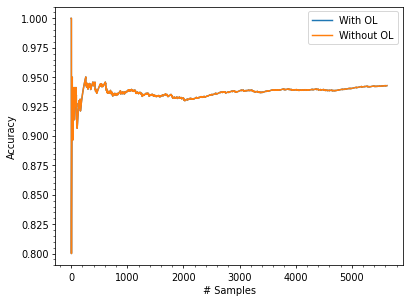

In [34]:
wrap_plot(OUTPUT_DIR + "bagging_om_test_incremental.csv",
          OUTPUT_DIR + "bagging_om_test_incremental_raw.csv",
          OUTPUT_DIR + "bagging_om_test_diff.pdf")

Now, try with a new Bagging classifier with copies of a **Pruned Model** with the same pruned parameters of the best one previously obtained.

In [35]:
set_seed()

x = globally_unstructured_connections_l1(EnhancedMlpClassifier.load(OUTPUT_DIR + f"om_tl_train_{BATCH_SIZE}"), best_prune_amount).clone(init=True)
bag = WrapRiverEnsemble(ensemble.LeveragingBaggingClassifier, model=x, n_models=3)
wrap_train(bag, OUTPUT_DIR + "bagging_pm", ds=train_ds);

  1%|          | 5/625 [00:00<00:14, 42.03it/s]

100%|██████████| 625/625 [00:15<00:00, 41.54it/s]


In [36]:
wrap_test(load(OUTPUT_DIR + "bagging_pm_train"), OUTPUT_DIR + "bagging_pm", ds=test_ds);

100%|██████████| 5627/5627 [02:20<00:00, 40.17it/s]


,Accuracy,Recall,Precision,F1,Drifts
With OL,0.942776,1.0,0.942776,0.970545,[]
Without OL,0.942776,1.0,0.942776,0.970545,NaN


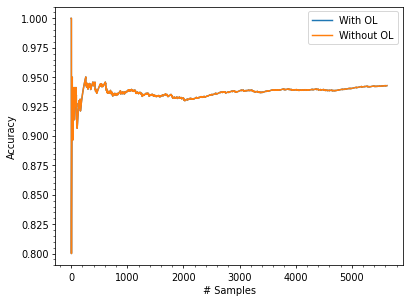

In [38]:
wrap_plot(OUTPUT_DIR + "bagging_pm_test_incremental.csv",
          OUTPUT_DIR + "bagging_pm_test_incremental_raw.csv",
          OUTPUT_DIR + "bagging_pm_test_diff.pdf")